# Notes

# Imports

In [8]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions 

In [9]:
def return_state_probabilities_from_state_tseries(state_tseries, numLabelledStates):
    ''' Return the probabilities of each state in the state_tseries. 
        Each value in state_tseries is between 0 and numLabelledStates-1, or NaN,
        or -1 if it was belonging to another cluster (nonlabelled cluster)
        Return the probability of each state as a vector, with the last entry being prob
        of another cluster, and NaN data excluded.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from -1,  
                   Can contains NaNs.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    state_probs: 1D array of shape (numLabelledStates+1,), containing the probability of 
                 each cluster idx and lastly the probability of nonlabelled clusters
    '''
    # add one state for -1 (nonlabelled cluster)
    numStates = numLabelledStates + 1
    # preallocate the output
    state_probs = np.zeros((numStates,))
    #  find the number of frames in total excluding NaN frames
    state_tseries_nanless = state_tseries[~np.isnan(state_tseries)]
    numFrames = state_tseries_nanless.shape[0]
    # if we have no non-nan frames, all probs are zero except the last
    if numFrames == 0:
        return state_probs
    else:
        # first compute main states probs
        for stateIdx in range(numLabelledStates):
            state_counts = np.where(state_tseries_nanless==stateIdx)[0].shape[0]
            state_probs[stateIdx] = state_counts / numFrames
        # now add the final NaN probability
        other_state_counts = np.where(state_tseries_nanless==-1)[0].shape[0]
        state_probs[-1] = other_state_counts / numFrames
        return state_probs


    
def compute_state_probabilities_in_time_windows(state_tseries, time_windows, numLabelledStates):
    ''' Compute the probability of each of the state indices in state_tseries, in
        each of the windows in time_windows.
    
    --- args ---
    state_tseries: a 1D timeseries of cluster indexes, starting from 0 to (numLabelledClusters-1)
                   for the labelled states, -1 for all nonlabelled states, and NaN for missing data.
    time_windows: array of shape (numWins,2), where each row contains a start frame
                  and a stop frame which define a region in time. The probabilities
                  are estimated in each of these regions in time.
    numLabelledStates: the number of state indices that should appear in state_tseries.
                       Pass this in case no values are found for some indices, in which
                       case we know how many zero probabilities to return.
               
    --- returns ---
    window_state_probabilities: a (numWinds, numLabelledStates+1) array containing the 
                                probability of each cluster idx and lastly the probability of 
                                nonlabelled cluster occuring. 
                                
    --- see also ---
    return_state_probabilities_from_state_tseries: 
    the function which does the main computation in each time window.
    
    '''
    numWins = time_windows.shape[0]
    window_state_probabilities = np.zeros((numWins, numLabelledStates+1)) # plus1 for the nonlabelled states
    for winIdx in range(numWins):
        w0,wE = time_windows[winIdx]
        win_data = state_tseries[w0:wE]
        win_state_probs = return_state_probabilities_from_state_tseries(win_data, numLabelledStates)
        window_state_probabilities[winIdx] = win_state_probs
    return window_state_probabilities

In [10]:
def return_region_win_state_probs(region_data, all_exp_window_state_probabilities, all_exp_time_windows, all_exp_numFrames):
    ''' Return the list over fight-bouts, containing the windowed state probabilities for the chosen region.
    
    --- args ---
    region_data: array (numBouts,3), where first col is exp idxs, 2nd and 3rd cols are the start/stop
                 frames of certain regions, e.g. 3 mins before a fightbout.
    
    all_exp_window_state_probabilities: the list over experiments, containing the windowed state probability of
                                        infomap clusters, e.g. each element of the list is a (numWins, 11) array,
                                        where 11 is the number of states and state vals sum to 1.
                                        
    all_exp_time_windows: the list over experiments, with elements being the time windows associated with the 
                          state probabilities in all_exp_window_state_probabilities.
                          
    all_exp_numFrames: a list over experiments containing the number of frames in each experiment.
                          
    --- return ---
    exps_region_win_state_probs: a list over fight bouts, where each element is a (numRegionWins,numStates) array
                                 of state proabilities for windows during the chosen region for a particular fight bout.
                                 
    --- see also ---
    find_time_window_indices_bounding_start_and_stop_frame()
    
    '''
    #exps_region_time_wins = []
    exps_region_win_state_probs = []

    skipped_bIdxs = []
    for bIdx in range(region_data.shape[0]):
        expIdx, t0, tE = region_data[bIdx]
        
        # if t0 is negative, exclude this fight bout
        # if tE is greater than the number of frames in the experiment, exclude fight bout
        if t0 < 0:
            skipped_bIdxs.append(bIdx)
            continue
        expnfs = expNumFrames[expIdx]
        if tE > expnfs:
            skipped_bIdxs.append(bIdx)
            continue

        exp_win_state_probs = all_exp_window_state_probabilities[expIdx]
        exp_time_wins = all_exp_time_windows[expIdx]

        desired_first_win_idx, desired_last_win_idx = find_time_window_indices_bounding_start_and_stop_frame(exp_time_wins, 
                                                                                                             t0, tE)

        #region_time_wins = exp_time_wins[desired_first_win_idx:desired_last_win_idx+1, :] #+1 to get the last win
        region_win_state_probs = np.copy(exp_win_state_probs[desired_first_win_idx:desired_last_win_idx+1, :])

        #exps_region_time_wins.append(region_time_wins)
        exps_region_win_state_probs.append(region_win_state_probs)
    
    
    return exps_region_win_state_probs



def find_time_window_indices_bounding_start_and_stop_frame(time_windows, startFrame, stopFrame):
    ''' Return the time window indices of which bound the startFrame and stopFrame.
    
    The idea is to allow for the parsing of time_windows, to choose only windows that contain
    no contributions for timepoints outside of the interval [startFrame, stopFrame]
    
    --- Example ---
    time_windows = np.array([[     0,   6000],
                            [   100,   6100],
                            [   200,   6200],
                            ...,
                            [711600, 717600],
                            [711700, 717700],
                            [711800, 717800]])
    startFrame = 36000
    stopFrame = 66000
                       
    desired_first_win_idx, desired_first_win_idx = f(time_windows, startFrame, stopFrame)
    time_windows[desired_first_win_idx] = array([36000, 42000])
    time_windows[desired_last_win_idx] = array([60000, 66000])                  
    
    -- returns --
    desired_first_win_idx, desired_first_win_idx: int, int
    
    '''
    desired_first_win_idx = np.where(time_windows[:,0] >= startFrame)[0][0]
    desired_last_win_idx = np.where(time_windows[:,1] >= stopFrame)[0][0]
    return desired_first_win_idx, desired_last_win_idx



def return_overlapping_windows_for_timeframes(numFrames, window_size=200, window_step=50):
    ''' Given a number of frames, return an 2D array of window start-stop frames.
    '''
    # define, for clarity, the first window
    win0_start = 0
    win0_mid = int(window_size/2)
    win0_end = int(window_size)

    # find numWindows, by adding incrementally and watching the last frame
    last_frame_in_windows = win0_end
    numWindows = 1
    while last_frame_in_windows < (numFrames - window_step):
        numWindows += 1
        last_frame_in_windows = win0_end + (numWindows-1)*window_step

    # now fill-in the windows array of frame indices
    windows = np.zeros((numWindows, 2))
    windows[0, 0] = 0
    windows[0, 1] = win0_end
    for winIdx in range(1, numWindows):
        w0 = winIdx*window_step
        wF = w0 + window_size
        windows[winIdx, 0] = w0
        windows[winIdx, 1] = wF
    return windows.astype(int)

# load the tracking data

In [11]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]

    


# load the post-processed tseries of infomap cluster idxs

In [7]:
# load
all_exps_edited_postProced_clusterIdx_tseries = []
postprocessed_all_exp_edited_cluster_tseries_savepath = os.path.join(os.path.dirname(infomap_data_loadpath),
                                                                     'postprocessed_exp_edited_clusterIdx_timeseries.h5')
with h5py.File(postprocessed_all_exp_edited_cluster_tseries_savepath, 'r') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        tseries = hf['{0}_clusterIdxs'.format(expName)][:]
        all_exps_edited_postProced_clusterIdx_tseries.append(tseries)
        
# make the master-set
clusterIdx_edited_postProced_tseries_master = np.concatenate(all_exps_edited_postProced_clusterIdx_tseries)
clusterIdx_edited_postProced_tseries_master.shape

(16044324,)

In [8]:
# We use these for plotting consistent fight maneuver colors across figures
colorlist = ['#ffe119', '#3cb44b', '#e6194B', '#4363d8', '#f58231', 
             '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', 
             '#469990', '#dcbeff', '#9A6324', '#800000', 
             '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'] 


In [9]:

# these are the state names of the clusterIdx_edited_postProced_tseries
all_state_names = ['circling',
                 'direct away',
                 'winner attack',
                 'loser attack',
                 'display',
                 'direct to',
                 'middle circling',
                 'L approach',
                 'W approach',
                 'parallel',
                 'non-fight clusters']

all_state_names

['circling',
 'direct away',
 'winner attack',
 'loser attack',
 'display',
 'direct to',
 'middle circling',
 'L approach',
 'W approach',
 'parallel',
 'non-fight clusters']

In [10]:
len(all_state_names)

11

In [11]:
numLabelledStates = len(all_state_names)-1
numLabelledStates


10

In [12]:
# -1 represent nonFight clusters
# NaN data means missing data
np.unique(clusterIdx_edited_postProced_tseries_master[~np.isnan(clusterIdx_edited_postProced_tseries_master)])

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

# Load the fight boundaries we have saved already

In [13]:
fightBouts_info_path

'/media/liam/hd1/fighting_data/tracking_results/fightBouts.h5'

In [14]:
with h5py.File(fightBouts_info_path, 'r') as hf:
    exps_fight_info = hf['refined_exps_fight_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]
    fight_bout_info = hf['fight_bout_info'][:]
    
fight_bout_info.shape

(18, 4)

In [15]:
exps_fight_info.shape

(45, 4)

In [16]:
fight_bout_info_noDurThresh.shape

(33, 4)

In [17]:
fight_bout_info.shape

(18, 4)

# Evaluate new slices of fight bouts

"exps_fight_info" is the 'rawest' output of the fight detector. 
From there, slice how you like

In [12]:
# ------------ make a dataframe for the fight info from all 22 exps --------------#

fight_cols = ['expIdxs', 'startIdx', 'stopIdx', 'durations']
fight_bout_df = pd.DataFrame(data=exps_fight_info, columns=fight_cols)

# make a column showing if the experiment ended with a conclusive winner and loser
ends_conclusive_arr = []
df_expIdxs_col = fight_bout_df['expIdxs'].values
for ii, expIdx in enumerate(df_expIdxs_col):
    ends_conclusive_arr.append(conclusive_winner_loser[expIdx])
ends_conclusive_arr = np.array(ends_conclusive_arr)
fight_bout_df['conclusive_winner'] = ends_conclusive_arr

# make a column showing if the experiment had an existing dominance relationship
existing_dominance_arr = []
df_expIdxs_col = fight_bout_df['expIdxs'].values
for ii, expIdx in enumerate(df_expIdxs_col):
    existing_dominance_arr.append(already_established_dominance[expIdx])
existing_dominance_arr = np.array(existing_dominance_arr)
fight_bout_df['existing_dominance'] = existing_dominance_arr



NameError: name 'exps_fight_info' is not defined

In [45]:
# # ---------    Apply criteria to fight bouts  ----------------------------------------#

# Note: you can add these to calculations below in this notebook.
#

# # 5 mins, for 2 2-minute segments wihoutout overlap, plus 6000 frames (i.e. 2 30sec frame segments for window overlap past 3 mins)
# duration_thresh_5min = 24000 + 6000  

# # selecting rows based on ending with clear winner/loser, and longer than frame gap
# bouts_g5_df = fight_bout_df.loc[(fight_bout_df['conclusive_winner'] == 1) &
#                                 (fight_bout_df['existing_dominance'] == 0) &
#                                 (fight_bout_df['durations'] >= (duration_thresh_5min))
#                                                          ]

In [43]:
#bouts_g5_df

# Prepare fight boundary sets

In [135]:


bouts_g7 = np.copy(fight_bout_info)
bouts_g2 = np.copy(fight_bout_info_noDurThresh)

fight_ensamble_names = ['> 7min', '> 2min']
bout_list = [bouts_g7, bouts_g2]


ensamble_durations_mins = [bouts_g7[:,-1]/6000,
                           bouts_g2[:,-1]/6000]

In [99]:
bouts_g2.shape

(33, 4)

In [100]:
bouts_g7.shape

(18, 4)

In [101]:
# -------------------------------------------------------------------------------------------------#
# Compute the loser maneuvers prob minus the winners maneuvers prob in the 2 mins before bouts end,
# for all ensambles of bouts
#--------------------------------------------------------------------------------------------------#



pre_fight_numFrames = int(2*6000) # 2mins

bout_list_losMan_minus_winMan = []

# ----------------------------------------------------------------#


for bouts_choice_index in range(len(bout_list)):

    bouts_choice_name = fight_ensamble_names[bouts_choice_index]
    bouts = np.copy(bout_list[bouts_choice_index])
    pre_fight_single_window_arr = np.array([0,pre_fight_numFrames]).reshape(-1,2)
    #print(bouts_choice_name)
    #print()


    # ----- get the 11-state pre-fight window probs  ---- #


    bouts_pre_fight_window_probs = []

    for bIdx in range(bouts.shape[0]):

        expIdx, f0, fE, dur = bouts[bIdx]

        bout_cls_tseries = np.copy(all_exps_edited_postProced_clusterIdx_tseries[expIdx][f0:fE])

        bout_last_N_frames_data = bout_cls_tseries[-pre_fight_numFrames:]

        bout_last_N_frames_data_probabilities = compute_state_probabilities_in_time_windows(bout_last_N_frames_data, pre_fight_single_window_arr, numLabelledStates)


        bouts_pre_fight_window_probs.append(bout_last_N_frames_data_probabilities)


    # ----- combine into 3-state system ---- #

    # numBouts, numStatesIntoOne
    winnerManeuver_probs = np.zeros((bouts.shape[0],2))*np.NaN
    loserManeuver_probs = np.zeros((bouts.shape[0],2))*np.NaN
    displayManeuver_probs = np.zeros((bouts.shape[0],4))*np.NaN

    for bIdx in range(bouts.shape[0]):

        probs = bouts_pre_fight_window_probs[bIdx].reshape(-1)

        winnerManeuver_probs[bIdx,0] = probs[2] #winner attack
        winnerManeuver_probs[bIdx,1] = probs[8] #winner app

        loserManeuver_probs[bIdx,0] = probs[3] #loser attack
        loserManeuver_probs[bIdx,1] = probs[7] #loser app

        displayManeuver_probs[bIdx,0] =  probs[0] # close circling
        displayManeuver_probs[bIdx,1] =  probs[4] # display
        displayManeuver_probs[bIdx,2] =  probs[6] # far circling
        displayManeuver_probs[bIdx,3] =  probs[9] # far parallel
        
    # sum the probs for each of the three categories
    winnerManeuver_probs = np.sum(winnerManeuver_probs,axis=1)
    loserManeuver_probs = np.sum(loserManeuver_probs,axis=1)
    displayManeuver_probs = np.sum(displayManeuver_probs,axis=1)
    
    
    
    # ----- compute the test statistic ---- #
    losMan_minus_winMan = loserManeuver_probs - winnerManeuver_probs
    
    
    
    # ---- record --- #
    bout_list_losMan_minus_winMan.append(losMan_minus_winMan)

    

In [102]:
bout_list_losMan_minus_winMan



[array([ 0.03780357,  0.02397423,  0.11289276,  0.02076663, -0.20160561,
         0.08036299,  0.00634396,  0.05191831,  0.04074464,  0.17454966,
        -0.09021749,  0.08771089,  0.12648795,  0.22047894, -0.17700454,
         0.01836467, -0.05742919, -0.03857567]),
 array([-0.32164855, -0.07950936,  0.03780357,  0.02136792,  0.03831286,
         0.02397423, -0.2165141 ,  0.11289276,  0.13623463,  0.02076663,
        -0.20160561, -0.12042827,  0.05223945,  0.08036299,  0.00634396,
         0.05191831, -0.16730837,  0.04074464,  0.17454966, -0.09021749,
         0.08771089, -0.17584586,  0.12648795,  0.22047894, -0.17700454,
        -0.05412682,  0.05294016, -0.02943468,  0.01836467,  0.03447199,
        -0.05742919, -0.03857567,  0.04116016])]

# Make the cumulative distribution plots

In [103]:
bout_list_losMan_minus_winMan[0]

array([ 0.03780357,  0.02397423,  0.11289276,  0.02076663, -0.20160561,
        0.08036299,  0.00634396,  0.05191831,  0.04074464,  0.17454966,
       -0.09021749,  0.08771089,  0.12648795,  0.22047894, -0.17700454,
        0.01836467, -0.05742919, -0.03857567])

In [257]:
# --------------- fraction positive --------------- #

for bouts_choice_index in range(len(bout_list_losMan_minus_winMan)):
    
    # parse inputs
    losMan_minus_winMan = bout_list_losMan_minus_winMan[bouts_choice_index]
    nme = fight_ensamble_names[bouts_choice_index]
    
    num_pos_bouts = losMan_minus_winMan[losMan_minus_winMan>+0].shape[0]
    num_neg_bouts= losMan_minus_winMan[losMan_minus_winMan<0].shape[0]
    
    print(f'numBouts = {losMan_minus_winMan.shape[0]}')
    print(f'num positive vals ={num_pos_bouts}, num negative vals ={num_neg_bouts},')
    print(f'positive % = {(num_pos_bouts/losMan_minus_winMan.shape[0])*100}')
    print(f'neg % = {(num_neg_bouts/losMan_minus_winMan.shape[0])*100}')
    print()
    
    #print(losMan_minus_winMan.shape[0], num_pos_bouts, num_neg_bouts)

numBouts = 18
num positive vals =13, num negative vals =5,
positive % = 72.22222222222221
neg % = 27.77777777777778

numBouts = 33
num positive vals =20, num negative vals =13,
positive % = 60.60606060606061
neg % = 39.39393939393939



In [255]:
100 - 72

28

In [256]:
100- 60.6

39.4

## v1

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
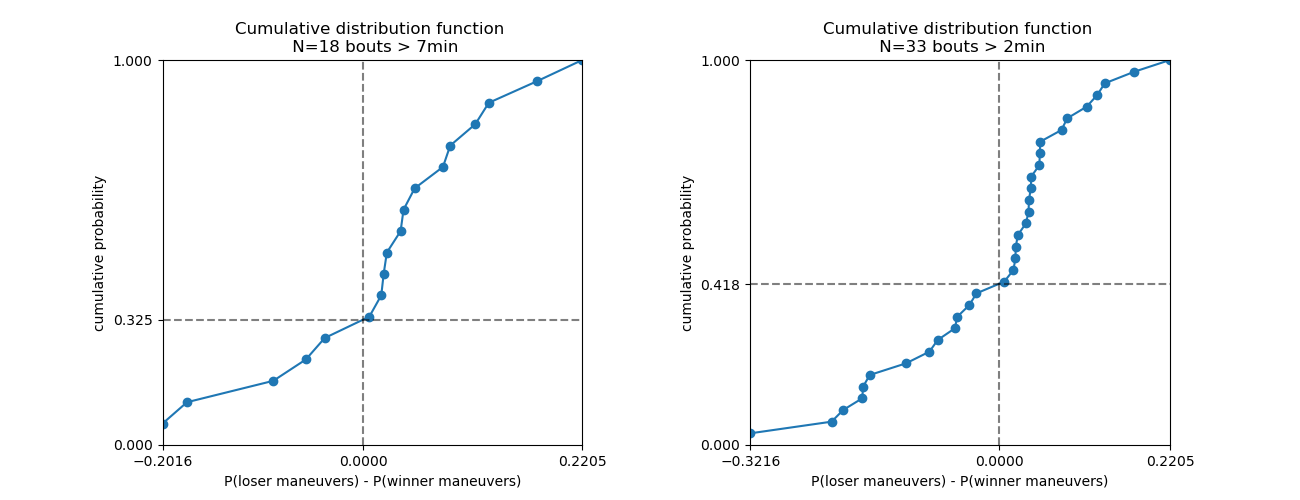

In [205]:
#  ---------- Two column plot -------------- #

numEnsambles = len(fight_ensamble_names)

xticks_list = [[np.min(bout_list_losMan_minus_winMan[0]), 0, np.max(bout_list_losMan_minus_winMan[0])],
               [np.min(bout_list_losMan_minus_winMan[1]), 0, np.max(bout_list_losMan_minus_winMan[1])]
              ]

# I determined these simply by examining the plot.
y_tick_intercepts = [0.325, 0.418]
yticks_list = [[0, y_tick_intercepts[0], 1],
               [0, y_tick_intercepts[1], 1]]


# ----------------------------------------------------------------------------------------------------#

fig, axs = plt.subplots(ncols=2, figsize=(13,5))
for bout_ensamble_index, ensamble_name in enumerate(fight_ensamble_names):

    # get the prob differences for this ensamble and sort low to high
    losMan_minus_winMan = bout_list_losMan_minus_winMan[bout_ensamble_index]
    sorted_data = np.sort(losMan_minus_winMan)

    # prepare the y-axis data for cum probs
    N = len(sorted_data)
    y_data = np.arange(1,N+1)/N

    # plot the data
    ax = axs[bout_ensamble_index]

    ax.plot(sorted_data, y_data, linestyle='-', marker='o', alpha=1)

    # set the axes limits
    ax.set_ylim(0,1)
    ax.set_xlim(np.min(sorted_data), np.max(sorted_data) )

    # draw the lines
    ax.axvline(0, linestyle='--',color='black', alpha=0.5)
    ax.axhline(y_tick_intercepts[bout_ensamble_index], alpha=0.5, linestyle='--',color='black')

    # set the ticks
    ax.set_xticks(xticks_list[bout_ensamble_index])
    ax.set_yticks(yticks_list[bout_ensamble_index])


    ax.set_title(f'Cumulative distribution function \n N={N} bouts {ensamble_name}')
    ax.set_ylabel('cumulative probability')
    ax.set_xlabel('P(loser maneuvers) - P(winner maneuvers)')

    #fig.tight_layout()
    #subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    # left  = 0.125  # the left side of the subplots of the figure
    # right = 0.9    # the right side of the subplots of the figure
    # bottom = 0.1   # the bottom of the subplots of the figure
    # top = 0.9      # the top of the subplots of the figure
    # wspace = 0.2   # the amount of width reserved for blank space between subplots
    # hspace = 0.2   # the amount of height reserved for white space between subplots
    fig.subplots_adjust(wspace=0.4)

## v2

In [196]:
from matplotlib.cm import ScalarMappable

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
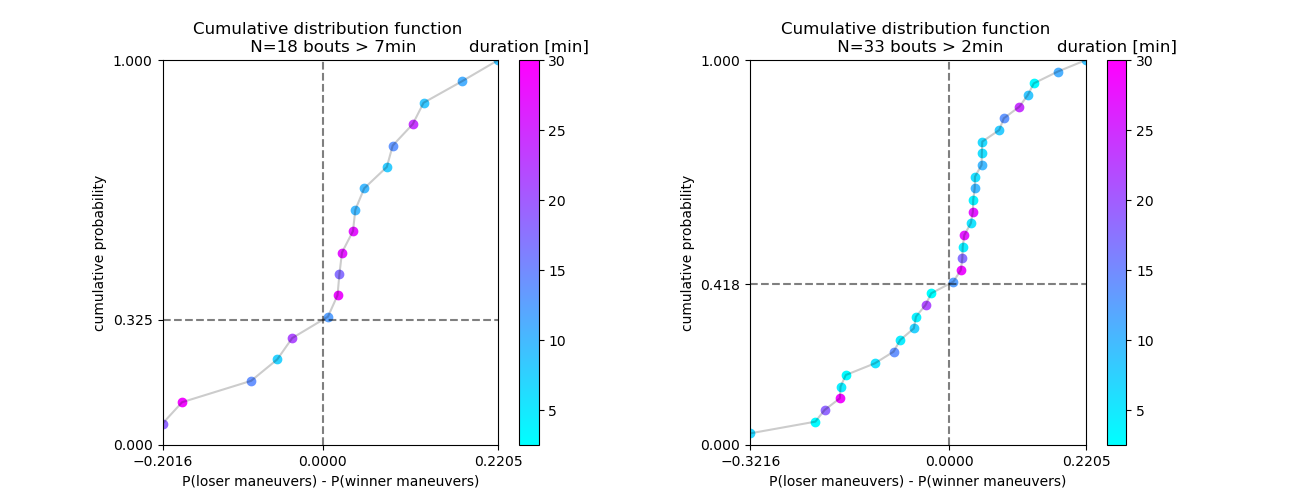

In [248]:
#  ---------- Two column plot -------------- #

numEnsambles = len(fight_ensamble_names)

# prepare the colorscale
cmap = plt.get_cmap("cool")
min_dur = 2.5
max_dur = 30
norm = plt.Normalize(min_dur, max_dur)

xticks_list = [[np.min(bout_list_losMan_minus_winMan[0]), 0, np.max(bout_list_losMan_minus_winMan[0])],
               [np.min(bout_list_losMan_minus_winMan[1]), 0, np.max(bout_list_losMan_minus_winMan[1])]
              ]

# I determined these simply by examining the plot.
y_tick_intercepts = [0.325, 0.418]
yticks_list = [[0, y_tick_intercepts[0], 1],
               [0, y_tick_intercepts[1], 1]]


# ----------------------------------------------------------------------------------------------------#

fig, axs = plt.subplots(ncols=2, figsize=(13,5))
for bout_ensamble_index, ensamble_name in enumerate(fight_ensamble_names):
    
    # prepare the colors for the scatters
    durs = ensamble_durations_mins[bout_ensamble_index]
    cols = cmap(norm(durs))
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    #sm.set_array([])

    # get the prob differences for this ensamble
    losMan_minus_winMan = bout_list_losMan_minus_winMan[bout_ensamble_index]
    
    # sort the data low to high and similarly rearrange the colors
    sorted_data = losMan_minus_winMan[np.argsort(losMan_minus_winMan)]
    cols = cols[np.argsort(losMan_minus_winMan)]


    # prepare the y-axis data for cum probs
    N = len(sorted_data)
    y_data = np.arange(1,N+1)/N

    # plot the data
    ax = axs[bout_ensamble_index]

    # plot the bouts colored by duration
    for boutIdx in range(N):
        ax.plot(sorted_data[boutIdx], y_data[boutIdx], c=cols[boutIdx], marker='o', alpha=1)
        
    # plot the lines joining the bouts
    ax.plot(sorted_data, y_data, c='black', linestyle='-', alpha=0.2)

    # set the axes limits
    ax.set_ylim(0,1)
    ax.set_xlim(np.min(sorted_data), np.max(sorted_data) )

    # draw the lines
    ax.axvline(0, linestyle='--',color='black', alpha=0.5)
    ax.axhline(y_tick_intercepts[bout_ensamble_index], alpha=0.5, linestyle='--',color='black')

    # set the ticks
    ax.set_xticks(xticks_list[bout_ensamble_index])
    ax.set_yticks(yticks_list[bout_ensamble_index])
    
    # set the colorbar
    cbar = fig.colorbar(sm, ax=ax)
    cbar.ax.set_title("duration [min]")


    ax.set_title(f'Cumulative distribution function \n N={N} bouts {ensamble_name}')
    ax.set_ylabel('cumulative probability')
    ax.set_xlabel('P(loser maneuvers) - P(winner maneuvers)')

    #fig.tight_layout()
    #subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    # left  = 0.125  # the left side of the subplots of the figure
    # right = 0.9    # the right side of the subplots of the figure
    # bottom = 0.1   # the bottom of the subplots of the figure
    # top = 0.9      # the top of the subplots of the figure
    # wspace = 0.2   # the amount of width reserved for blank space between subplots
    # hspace = 0.2   # the amount of height reserved for white space between subplots
    
    
fig.subplots_adjust(wspace=0.4)

## v3

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
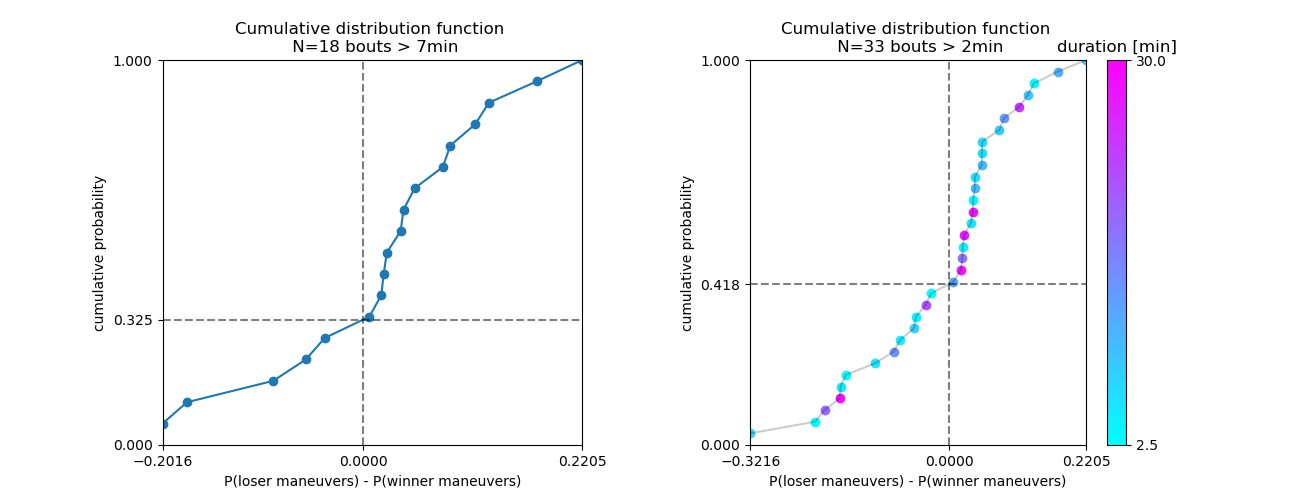

In [253]:
#  ---------- Two column plot -------------- #

numEnsambles = len(fight_ensamble_names)

# prepare the colorscale
cmap = plt.get_cmap("cool")
min_dur = 2.5
max_dur = 30
norm = plt.Normalize(min_dur, max_dur)

xticks_list = [[np.min(bout_list_losMan_minus_winMan[0]), 0, np.max(bout_list_losMan_minus_winMan[0])],
               [np.min(bout_list_losMan_minus_winMan[1]), 0, np.max(bout_list_losMan_minus_winMan[1])]
              ]

# I determined these simply by examining the plot.
y_tick_intercepts = [0.325, 0.418]
yticks_list = [[0, y_tick_intercepts[0], 1],
               [0, y_tick_intercepts[1], 1]]


# ----------------------------------------------------------------------------------------------------#

fig, axs = plt.subplots(ncols=2, figsize=(13,5))






bout_ensamble_index = 0
ensamble_name = fight_ensamble_names[bout_ensamble_index]

# get the prob differences for this ensamble and sort low to high
losMan_minus_winMan = bout_list_losMan_minus_winMan[bout_ensamble_index]
sorted_data = np.sort(losMan_minus_winMan)

# prepare the y-axis data for cum probs
N = len(sorted_data)
y_data = np.arange(1,N+1)/N

# plot the data
ax = axs[bout_ensamble_index]

ax.plot(sorted_data, y_data, linestyle='-', marker='o', alpha=1)

# set the axes limits
ax.set_ylim(0,1)
ax.set_xlim(np.min(sorted_data), np.max(sorted_data) )

# draw the lines
ax.axvline(0, linestyle='--',color='black', alpha=0.5)
ax.axhline(y_tick_intercepts[bout_ensamble_index], alpha=0.5, linestyle='--',color='black')

# set the ticks
ax.set_xticks(xticks_list[bout_ensamble_index])
ax.set_yticks(yticks_list[bout_ensamble_index])


ax.set_title(f'Cumulative distribution function \n N={N} bouts {ensamble_name}')
ax.set_ylabel('cumulative probability')
ax.set_xlabel('P(loser maneuvers) - P(winner maneuvers)')






bout_ensamble_index = 1
ensamble_name = fight_ensamble_names[bout_ensamble_index]

# prepare the colors for the scatters
durs = ensamble_durations_mins[bout_ensamble_index]
cols = cmap(norm(durs))
sm =  ScalarMappable(norm=norm, cmap=cmap)
#sm.set_array([])

# get the prob differences for this ensamble
losMan_minus_winMan = bout_list_losMan_minus_winMan[bout_ensamble_index]

# sort the data low to high and similarly rearrange the colors
sorted_data = losMan_minus_winMan[np.argsort(losMan_minus_winMan)]
cols = cols[np.argsort(losMan_minus_winMan)]


# prepare the y-axis data for cum probs
N = len(sorted_data)
y_data = np.arange(1,N+1)/N

# plot the data
ax = axs[bout_ensamble_index]

# plot the bouts colored by duration
for boutIdx in range(N):
    ax.plot(sorted_data[boutIdx], y_data[boutIdx], c=cols[boutIdx], marker='o', alpha=1)

# plot the lines joining the bouts
ax.plot(sorted_data, y_data, c='black', linestyle='-', alpha=0.2)

# set the axes limits
ax.set_ylim(0,1)
ax.set_xlim(np.min(sorted_data), np.max(sorted_data) )

# draw the lines
ax.axvline(0, linestyle='--',color='black', alpha=0.5)
ax.axhline(y_tick_intercepts[bout_ensamble_index], alpha=0.5, linestyle='--',color='black')

# set the ticks
ax.set_xticks(xticks_list[bout_ensamble_index])
ax.set_yticks(yticks_list[bout_ensamble_index])

# set the colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.set_title("duration [min]")
cbar.set_ticks([2.5,30])
#cbar.set_ticklabels([mn,md,mx]


ax.set_title(f'Cumulative distribution function \n N={N} bouts {ensamble_name}')
ax.set_ylabel('cumulative probability')
ax.set_xlabel('P(loser maneuvers) - P(winner maneuvers)')





    
    
fig.subplots_adjust(wspace=0.4)

## paper version

In [258]:
3.85*2

7.7

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
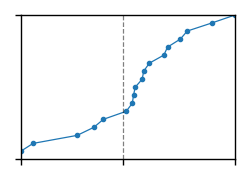

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
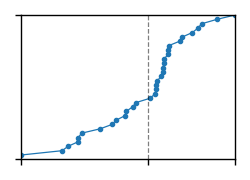

In [294]:
#  ---------- Two column plot -------------- #

numEnsambles = len(fight_ensamble_names)

xticks_list = [[np.min(bout_list_losMan_minus_winMan[0]), 0, np.max(bout_list_losMan_minus_winMan[0])],
               [np.min(bout_list_losMan_minus_winMan[1]), 0, np.max(bout_list_losMan_minus_winMan[1])]
              ]

# I determined these simply by examining the plot.
y_tick_intercepts = [0.325, 0.418]
yticks_list = [[0, 1],
               [0, 1]]


# ----------------------------------------------------------------------------------------------------#

fig, axs = plt.subplots(ncols=1, figsize=(2.5,1.8))
ax = axs

bout_ensamble_index = 0
ensamble_name = fight_ensamble_names[bout_ensamble_index]

# get the prob differences for this ensamble and sort low to high
losMan_minus_winMan = bout_list_losMan_minus_winMan[bout_ensamble_index]
sorted_data = np.sort(losMan_minus_winMan)

# prepare the y-axis data for cum probs
N = len(sorted_data)
y_data = np.arange(1,N+1)/N

# plot the data
ax.plot(sorted_data, y_data, linestyle='-', marker='o', alpha=1, linewidth=0.9, markersize=3)

# set the axes limits
ax.set_ylim(0,1)
ax.set_xlim(np.min(sorted_data), np.max(sorted_data) )

# draw the lines
ax.axvline(0, linestyle='--',color='black', linewidth=0.9, alpha=0.5)
#ax.axhline(y_tick_intercepts[bout_ensamble_index], alpha=0.5, linestyle='--',color='black')

# set the ticks
ax.set_xticks(xticks_list[bout_ensamble_index])
ax.set_yticks(yticks_list[bout_ensamble_index])

ax.set_title('')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_fig7SI_A.png'
fig.savefig(imsavepath, transparent=True, dpi=300)



# ----------------------------------------------------------------------------------------------------#

fig, axs = plt.subplots(ncols=1, figsize=(2.5,1.8))
ax = axs

bout_ensamble_index = 1
ensamble_name = fight_ensamble_names[bout_ensamble_index]

# get the prob differences for this ensamble and sort low to high
losMan_minus_winMan = bout_list_losMan_minus_winMan[bout_ensamble_index]
sorted_data = np.sort(losMan_minus_winMan)

# prepare the y-axis data for cum probs
N = len(sorted_data)
y_data = np.arange(1,N+1)/N

# plot the data
ax.plot(sorted_data, y_data, linestyle='-', marker='o', alpha=1, linewidth=0.9, markersize=3)

# set the axes limits
ax.set_ylim(0,1)
ax.set_xlim(np.min(sorted_data), np.max(sorted_data) )

# draw the lines
ax.axvline(0, linestyle='--', linewidth=0.9, color='black', alpha=0.5)
#ax.axhline(y_tick_intercepts[bout_ensamble_index], alpha=0.5, linestyle='--',color='black')

# set the ticks
ax.set_xticks(xticks_list[bout_ensamble_index])
ax.set_yticks(yticks_list[bout_ensamble_index])

ax.set_title('')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_fig7SI_B.png'
fig.savefig(imsavepath, transparent=True, dpi=300)


## paper version with horizontal line

0.2777777777777778
0.3939393939393939


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
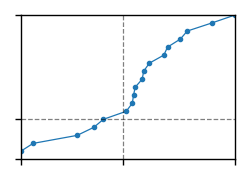

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
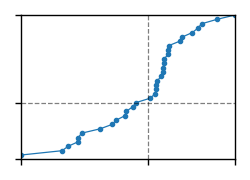

In [306]:
#  ---------- Two column plot -------------- #

numEnsambles = len(fight_ensamble_names)

xticks_list = [[np.min(bout_list_losMan_minus_winMan[0]), 0, np.max(bout_list_losMan_minus_winMan[0])],
               [np.min(bout_list_losMan_minus_winMan[1]), 0, np.max(bout_list_losMan_minus_winMan[1])]
              ]

last_negative_bout_idxs = [4, 12]



# ----------------------------------------------------------------------------------------------------#

fig, axs = plt.subplots(ncols=1, figsize=(2.5,1.8))
ax = axs

bout_ensamble_index = 0
ensamble_name = fight_ensamble_names[bout_ensamble_index]
last_negative_bout_idx = last_negative_bout_idxs[bout_ensamble_index]

# get the prob differences for this ensamble and sort low to high
losMan_minus_winMan = bout_list_losMan_minus_winMan[bout_ensamble_index]
sorted_data = np.sort(losMan_minus_winMan)

# prepare the y-axis data for cum probs
N = len(sorted_data)
y_data = np.arange(1,N+1)/N

# plot the data
ax.plot(sorted_data, y_data, linestyle='-', marker='o', alpha=1, linewidth=0.9, markersize=3)

# set the axes limits
ax.set_ylim(0,1)
ax.set_xlim(np.min(sorted_data), np.max(sorted_data) )

# draw the lines
ax.axvline(0, linestyle='--',color='black', linewidth=0.9, alpha=0.5)
ax.axhline(y_data[last_negative_bout_idx], alpha=0.5, linewidth=0.9, linestyle='--',color='black')
print(y_data[last_negative_bout_idx])

# set the ticks
ax.set_xticks(xticks_list[bout_ensamble_index])
ax.set_yticks([0, y_data[last_negative_bout_idx], 1] )

ax.set_title('')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_fig7SI_A_v2.png'
fig.savefig(imsavepath, transparent=True, dpi=300)



# ----------------------------------------------------------------------------------------------------#

fig, axs = plt.subplots(ncols=1, figsize=(2.5,1.8))
ax = axs

bout_ensamble_index = 1
ensamble_name = fight_ensamble_names[bout_ensamble_index]
last_negative_bout_idx = last_negative_bout_idxs[bout_ensamble_index]

# get the prob differences for this ensamble and sort low to high
losMan_minus_winMan = bout_list_losMan_minus_winMan[bout_ensamble_index]
sorted_data = np.sort(losMan_minus_winMan)

# prepare the y-axis data for cum probs
N = len(sorted_data)
y_data = np.arange(1,N+1)/N

# plot the data
ax.plot(sorted_data, y_data, linestyle='-', marker='o', alpha=1, linewidth=0.9, markersize=3)

# set the axes limits
ax.set_ylim(0,1)
ax.set_xlim(np.min(sorted_data), np.max(sorted_data) )

# draw the lines
ax.axvline(0, linestyle='--',color='black', linewidth=0.9, alpha=0.5)
ax.axhline(y_data[last_negative_bout_idx], alpha=0.5, linewidth=0.9, linestyle='--',color='black')
print(y_data[last_negative_bout_idx])

# set the ticks
ax.set_xticks(xticks_list[bout_ensamble_index])
ax.set_yticks([0, y_data[last_negative_bout_idx], 1] )

ax.set_title('')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.xaxis.set_tick_params(width=1, length=4)
ax.yaxis.set_tick_params(width=1, length=4)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1)

fig.tight_layout()

imsavepath = '/home/liam/temp/image_transfer/SI_fig7SI_B_v2.png'
fig.savefig(imsavepath, transparent=True, dpi=300)


## bootstrapping the P(pos)

We are going to bootstrap over bouts

In [307]:
bout_list_losMan_minus_winMan

[array([ 0.03780357,  0.02397423,  0.11289276,  0.02076663, -0.20160561,
         0.08036299,  0.00634396,  0.05191831,  0.04074464,  0.17454966,
        -0.09021749,  0.08771089,  0.12648795,  0.22047894, -0.17700454,
         0.01836467, -0.05742919, -0.03857567]),
 array([-0.32164855, -0.07950936,  0.03780357,  0.02136792,  0.03831286,
         0.02397423, -0.2165141 ,  0.11289276,  0.13623463,  0.02076663,
        -0.20160561, -0.12042827,  0.05223945,  0.08036299,  0.00634396,
         0.05191831, -0.16730837,  0.04074464,  0.17454966, -0.09021749,
         0.08771089, -0.17584586,  0.12648795,  0.22047894, -0.17700454,
        -0.05412682,  0.05294016, -0.02943468,  0.01836467,  0.03447199,
        -0.05742919, -0.03857567,  0.04116016])]

In [321]:
# --------- means --------- #
ensamble_mean_p_pos = []

for ensambleIdx in range(len(bout_list_losMan_minus_winMan)):
    ensamble_bout_prob_diffs = bout_list_losMan_minus_winMan[ensambleIdx]
    ensamble_num_pos_bouts = ensamble_bout_prob_diffs[ensamble_bout_prob_diffs>0].shape[0]
    ensamble_p_pos = ensamble_num_pos_bouts/ensamble_bout_prob_diffs.shape[0]
    ensamble_mean_p_pos.append(ensamble_p_pos)

ensamble_mean_p_pos

[0.7222222222222222, 0.6060606060606061]

In [332]:
# ----------------------- bootstrap ------------------------------#
t0 = time.perf_counter()


# args
confidence_interval=95
n_resamples=1000
per=(100-confidence_interval)/2

ensamble_err_p_pos = []



panelA_resamples_prob_pos = []
ensamble_bout_prob_diffs = bout_list_losMan_minus_winMan[0]
for i in range(n_resamples):
    # the number of bouts we have access to
    numSamples = ensamble_bout_prob_diffs.shape[0] 
    #  get the bout indices for this resample 
    indices=np.random.choice(range(0,numSamples), numSamples)
    # gather the data for this resampling
    sample_bout_prob_diffs = np.zeros_like(ensamble_bout_prob_diffs)*np.NaN
    for idx,boutIdx in enumerate(indices):
        sample_bout_prob_diffs[idx] = ensamble_bout_prob_diffs[boutIdx]
    # get the positive probability for the sample
    sample_num_pos_bouts = sample_bout_prob_diffs[sample_bout_prob_diffs>+0].shape[0]
    sample_p_pos = (sample_num_pos_bouts/numSamples)
    # record
    panelA_resamples_prob_pos.append(sample_p_pos)
# turn into array
panelA_resamples_prob_pos = np.array(panelA_resamples_prob_pos)
# get the standard deviation of distribution of means
bootstrap_std_panelA_prob_pos = np.std(panelA_resamples_prob_pos, axis=0)
ensamble_err_p_pos.append(bootstrap_std_panelA_prob_pos)


panelB_resamples_prob_pos = []
ensamble_bout_prob_diffs = bout_list_losMan_minus_winMan[1]
for i in range(n_resamples):
    # the number of bouts we have access to
    numSamples = ensamble_bout_prob_diffs.shape[0] 
    #  get the bout indices for this resample 
    indices=np.random.choice(range(0,numSamples), numSamples)
    # gather the data for this resampling
    sample_bout_prob_diffs = np.zeros_like(ensamble_bout_prob_diffs)*np.NaN
    for idx,boutIdx in enumerate(indices):
        sample_bout_prob_diffs[idx] = ensamble_bout_prob_diffs[boutIdx]
    # get the positive probability for the sample
    sample_num_pos_bouts = sample_bout_prob_diffs[sample_bout_prob_diffs>+0].shape[0]
    sample_p_pos = (sample_num_pos_bouts/numSamples)
    # record
    panelB_resamples_prob_pos.append(sample_p_pos)
# turn into array
panelB_resamples_prob_pos = np.array(panelB_resamples_prob_pos)
# get the standard deviation of distribution of means
bootstrap_std_panelB_prob_pos = np.std(panelB_resamples_prob_pos, axis=0)
ensamble_err_p_pos.append(bootstrap_std_panelB_prob_pos)      



ensamble_err_p_pos

[0.10514209961338565, 0.0824028437017664]

In [333]:
ensamble_mean_p_pos

[0.7222222222222222, 0.6060606060606061]

In [334]:
ensamble_err_p_pos

[0.10514209961338565, 0.0824028437017664]

In [ ]:
0.72 \pm 0.11

In [336]:
0.61 \pm 0.08